# Helmet Mapping: fitering out excess NGS players
Reference: https://www.kaggle.com/its7171/nfl-baseline-simple-helmet-mapping

In [1]:
# # Developer
# %cd /kaggle
# from IPython.display import clear_output
# pat = input('Personal Access Token:')
# clear_output()
# ! git clone https://$pat@github.com/qAp/nfl_helmet_assignment_kaggle.git

# %cd /kaggle/nfl_helmet_assignment_kaggle/
# ! git pull

In [2]:
# User
! cp -r /kaggle/input/nfl-helmet-assignment-kaggle/nfl_helmet_assignment_kaggle /kaggle/.

In [3]:
import os, sys
import importlib
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

sys.path.append('/kaggle/nfl_helmet_assignment_kaggle/')
from helmet_tracker.utils.features import add_track_features
from helmet_tracker.models.helmet_mapping import *
from helmet_tracker.util import create_football_field

In [4]:
# import helmet_tracker
# importlib.reload(helmet_tracker.models.helmet_mapping)

In [5]:
def plt_frame(video, frame, t=None, idxs_discard=None):
    
    pth_video = os.path.join(dir_video, video + '.mp4')

    # Get helmets for selected video and frame
    df_helmets = helmets.query('video==@video and frame==@frame')

    # Get NGS players for selected video and frame
    gameKey, playID, view = video.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
    nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
    df_ngs = df_ngs.query('est_frame==@nearest_est_frame')

    # Draw a circle around each helmet
    cap = cv2.VideoCapture(pth_video)
    for _ in range(frame):
        read_ok, img = cap.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in df_helmets.itertuples():
        img = cv2.circle(img, 
                         center=(
                             int(box.left + 0.5 * box.width), 
                             int(box.top + 0.5 * box.height)
                         ), 
                         radius=10, color=(255, 255, 255), thickness=5, )

    # Show helmets and NGS players
    fig, axs = plt.subplots(figsize=(15, 8), nrows=1, ncols=2)
    
    axs[0].imshow(img)
    axs[0].set_title('Camera frame')
    
    # Rotate NGS frame if needed
    if t is not None:
        df_t = rotate_dataframe(df_ngs, t=t)
    else:
        df_t = df_ngs.copy()
        
    for team, d in df_t.groupby('team'):
        x, y = d[['x', 'y']].values.T
        axs[1].scatter(x, y, label=team)
        for x_, y_, label in zip(x, y, d['player'].values):
            axs[1].text(x_, y_, label)

    # Indicate discarded NGS players
    if idxs_discard is not None:        
        df_t = df_t.reset_index(drop=True).copy()
        to_discard = df_t.index.isin(idxs_discard)
        df_discard = df_t[to_discard]
        axs[1].scatter(df_discard['x'].values, df_discard['y'].values,
                       color='black', marker='x', s=100, zorder=6)

    axs[1].set_title(f'NGS frame')
    axs[1].grid(b=True)

    plt.tight_layout();
    
    return fig, axs

# Basic data import

In [6]:
debug = True
CONF_THRE = 0.3
BASE_DIR = '/kaggle/input/nfl-health-and-safety-helmet-assignment/'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
if debug:
    dir_video = os.path.join(BASE_DIR, 'train')
    tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
else:
    dir_video = os.pth.join(BASE_DIR, 'test')
    tracking = pd.read_csv(f'{BASE_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')

In [7]:
%%time

# Add estimated video frame to NGS data

tracking = add_track_features(tracking) 

CPU times: user 1.67 s, sys: 72.7 ms, total: 1.74 s
Wall time: 1.76 s


In [8]:
# Select a couple of examples for debugging.

if debug:
    sample_keys = random.sample(list(tracking['gameKey'].unique()), 3)
    
    helmets['gameKey'] = helmets['video_frame'].str.split('_').str[0]
    
    tracking = tracking[tracking['gameKey'].isin(sample_keys)]
    helmets = helmets[helmets['gameKey'].astype(int).isin(sample_keys)]
    labels = labels[labels['gameKey'].astype(int).isin(sample_keys)]

In [9]:
helmets['video'] = helmets['video_frame'].str.split('_').str[:3].str.join('_')
helmets['frame'] = helmets['video_frame'].str.split('_').str[3].astype(int)

# Helmets and NGS players in a selected video frame

In [10]:
# Select some video and some frame.

video = helmets['video'].unique()[2]
frame = 209

In [11]:
pth_video = os.path.join(dir_video, video + '.mp4')
pth_video

'/kaggle/input/nfl-health-and-safety-helmet-assignment/train/58106_002918_Sideline.mp4'

In [12]:
# Get tracking data

gameKey, playID, view = video.split('_')
gameKey = int(gameKey)
playID = int(playID)
df_ngs = tracking.query('gameKey==@gameKey and playID==@playID')
nearest_est_frame = find_nearest(df_ngs['est_frame'].values, frame)
df_ngs = df_ngs.query('est_frame==@nearest_est_frame')

In [13]:
# Get helmets

df_hel = helmets.query('video==@video and frame==@frame')

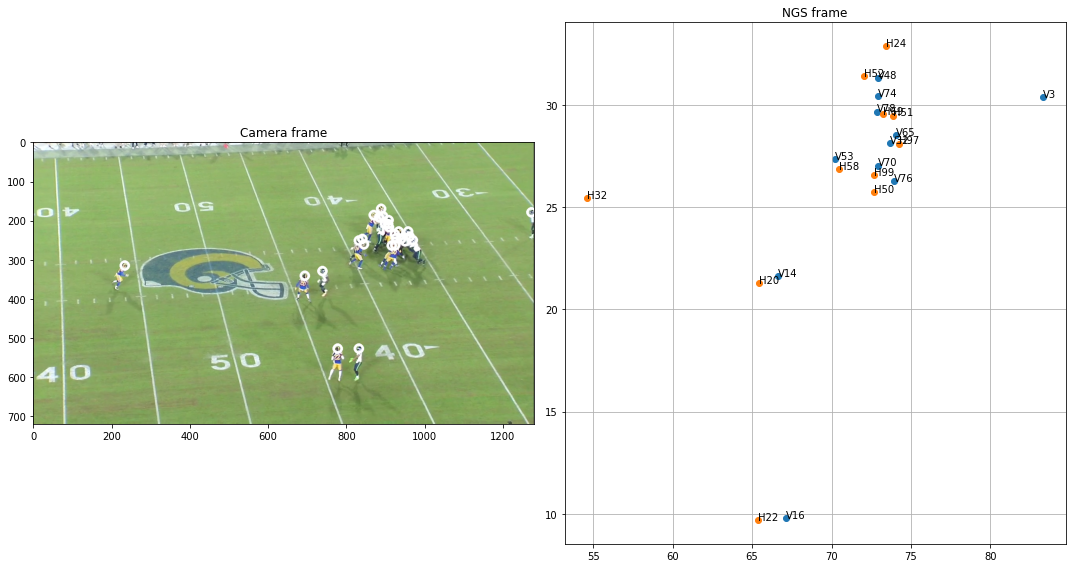

In [14]:
fig, axs = plt_frame(video, frame,)

# Filter out different NGS players and compute distance

In [15]:
# Clean detected helmets

df_hel = df_hel[df_hel['conf'] > CONF_THRE].copy()

if len(df_hel) > len(df_ngs):
    df_hel = df_hel.tail(len(df_ngs))

In [16]:
# Get the coordinates of helmet centres

df_hel['helmet_center_x'] = df_hel['left'] + df_hel['width'] / 2
df_hel['helmet_center_y'] = df_hel['top'] + df_hel['height'] / 2

xy_hel = df_hel[['helmet_center_x', 'helmet_center_y']].values

In [17]:
# Sort helmets by their x-coordinate, then nornamlise x and y independently

xy_hel = xy_hel[xy_hel[:, 0].argsort()]

xy_hel -= xy_hel.min(axis=0, keepdims=True)
xy_hel /= xy_hel.max(axis=0, keepdims=True)

In [18]:
# Get NGS player centres

xy_ngs = df_ngs[['x', 'y']].values

In [19]:
# Eyeball the rotation angle required for NGS frame
# for players' positions to match helmets' positions

t_rough = -90

xy_ngs = rotate_arr(xy_ngs.T, t_rough).T

In [20]:
len(xy_ngs), len(xy_hel)

(22, 22)

In [21]:
# Make number of players equal number of helmets
# Compute distance score, keeping the minimum

assert len(xy_ngs) >= len(xy_hel)

num_discard = len(xy_ngs) - len(xy_hel)

max_iter = 1000

if num_discard == 0:
    xy = xy_ngs
    
    xy = xy[xy[:, 0].argsort()]

    xy -= xy.min(axis=0, keepdims=True)
    xy /= xy.max(axis=0, keepdims=True)
    
    min_dist_score = dist(xy_hel, xy)
    min_idxs_discard = ()
    
else:
    
    min_dist_score = 10_000
    min_idxs_discard = None
    for i in range(max_iter):
        print(f'\r{i + 1}/{max_iter} Filter players', end='', flush=True)
        idxs_discard = random.sample(range(len(xy_ngs)), num_discard)
        xy = np.delete(xy_ngs, idxs_discard, axis=0)
        
        xy = xy[xy[:, 0].argsort()]
        
        xy -= xy.min(axis=0, keepdims=True)
        xy /= xy.max(axis=0, keepdims=True)
        
        dist_score = dist(xy_hel, xy)
        
        if dist_score < min_dist_score:
            min_dist_score = dist_score
            min_idxs_discard = idxs_discard

In [22]:
min_idxs_discard, min_dist_score

((), 1.7034888453100139)

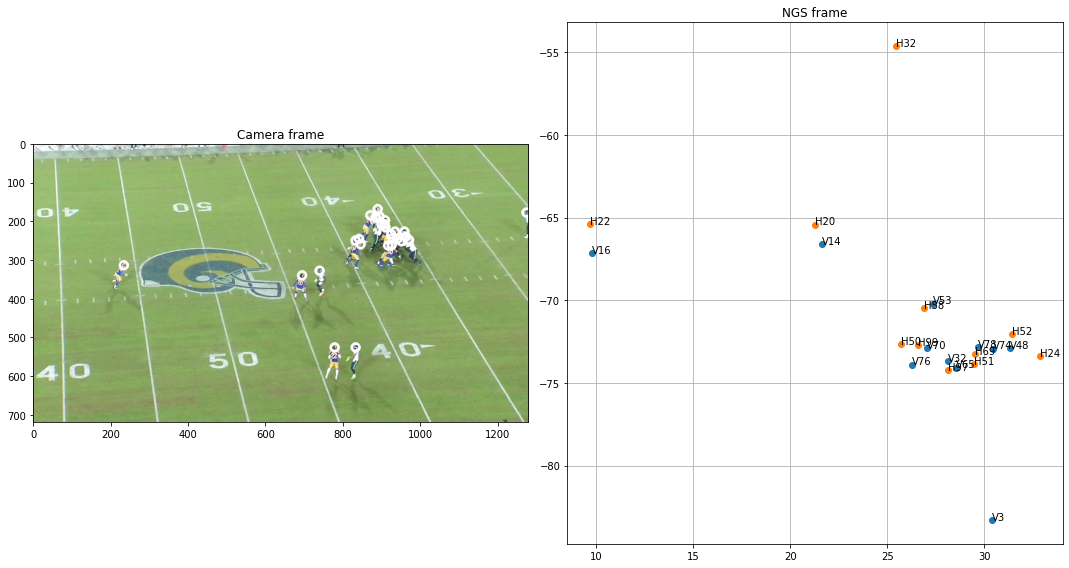

In [23]:
fig, ax = plt_frame(video, frame, t_rough, min_idxs_discard)